# Variable importance using SHAP
***

I wanted to investigate the importance of rating variables on sales and performance. Had an idea of which new variables could be of use, but wanted to investigate the likelihood of this. Used SHAP to determine the feature importance to support further modelling and presentations to key stakeholders 

**Figures anonymised and scrambled so it is no an extract from real data**



In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt  
import matplotlib as mpl
import seaborn as sns         
from sklearn.model_selection import train_test_split

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
Data = pd.read_csv('Variable_data.csv', low_memory=False)

## Prep data for model
***

***Deletion of columns and reduction of dataframe in this example removed from notebook***

In [4]:
all_cols = list(Data.columns)
#print(all_cols)

In [5]:
Data_sorted = Data

In [6]:
## Remove columns that are not needed for this to reduce file size
unwanted_cols = []
Data_sorted = Data_sorted.drop(columns=unwanted_cols)

In [6]:
## Remove where VAR_MATCH = N 
Data_filtered = Data_sorted[Data_sorted['VAR_MATCH'] == 'Y']

In [7]:
Data_filtered['VAR_MATCH'].unique()

array(['Y'], dtype=object)

In [8]:
Data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74787 entries, 0 to 80366
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 74787 non-null  int64  
 1   RI_AGE             74787 non-null  int64  
 2   CREDIT_SCORE       74598 non-null  float64
 3   VEHICLE_AGE        74787 non-null  int64  
 4   VEHICLE_VALUE      74787 non-null  int64  
 5   VAR_MATCH          74787 non-null  object 
 6   VAR1               71774 non-null  float64
 7   VAR2               71774 non-null  float64
 8   EXP                59008 non-null  float64
 9   EARNED_COMMISSION  59008 non-null  float64
 10  GEP                59008 non-null  float64
 11  GROSS_INCURRED     1725 non-null   float64
 12  SMOOTHED_INCURRED  59008 non-null  float64
dtypes: float64(8), int64(4), object(1)
memory usage: 8.0+ MB


In [9]:
# Calculate the mean of VAR1 and replace blanks with it
Var1_mean = Data_filtered['VAR1'].mean()
Data_filtered['VAR1'] = Data_filtered['VAR1'].fillna(Var1_mean)

In [10]:
# Calculate the mean of NC6 and replace blanks with it
Var2_mean = Data_filtered['VAR2'].mean()
Data_filtered['VAR2'] = Data_filtered['VAR2'].fillna(Var2_mean)


In [11]:
# Calculate the mean of credit_score and replace blanks with it
credit_mean = Data_filtered['CREDIT_SCORE'].mean()
Data_filtered['CREDIT_SCORE'] = Data_filtered['CREDIT_SCORE'].fillna(credit_mean)

In [12]:
Data_filtered['CREDIT_SCORE'] = Data_filtered['CREDIT_SCORE'].astype(int)

In [13]:
## turn vehicle values into banded nearest 500 figures
Data_filtered['VEHICLE_VALUE'] = (Data_filtered['VEHICLE_VALUE']+250)//500*500

In [14]:
Data_filtered.isnull().sum()

ID                       0
RI_AGE                   0
CREDIT_SCORE             0
VEHICLE_AGE              0
VEHICLE_VALUE            0
VAR_MATCH                0
VAR1                     0
VAR2                     0
EXP                  15779
EARNED_COMMISSION    15779
GEP                  15779
GROSS_INCURRED       73062
SMOOTHED_INCURRED    15779
dtype: int64

## Create target variables for calculations (Burn cost)
***

In [15]:
# New df to save running above if issue
Var_Burn = Data_filtered

In [16]:
# Fill na for values to calculate burn cost
Var_Burn['EXP'] = Var_Burn['EXP'].fillna(0)
#NECTAR_Burn['EXPOSURE'] = NECTAR_Burn['EXPOSURE'].astype(int)

Var_Burn['GROSS_INCURRED'] = Var_Burn['GROSS_INCURRED'].fillna(0)
#NECTAR_Burn['GROSS_INCURRED'] = NECTAR_Burn['GROSS_INCURRED'].astype(int)

In [17]:
Var_Burn['Gross_BC'] = Var_Burn['GROSS_INCURRED'] /Var_Burn['EXP']

In [18]:
Var_Burn.head(5)

,ID,RI_AGE,CREDIT_SCORE,VEHICLE_AGE,VEHICLE_VALUE,VAR_MATCH,VAR1,VAR2,EXP,EARNED_COMMISSION,GEP,GROSS_INCURRED,SMOOTHED_INCURRED,Gross_BC
0,1,67,771,5,8500,Y,42.0,49.0,0.005464,0.0,1.179285,0.0,0.283232,0.0
1,2,62,837,2,33000,Y,23.0,29.0,0.000000,0.0,0.000000,0.0,0.000000,NaN
2,3,68,777,1,20500,Y,36.0,26.0,0.000000,0.0,0.000000,0.0,0.000000,NaN
3,4,62,744,4,11500,Y,24.0,9.0,0.000000,0.0,0.000000,0.0,0.000000,NaN
4,5,73,815,1,9000,Y,43.0,22.0,0.008197,0.0,2.507864,0.0,0.653308,0.0


In [19]:
Var_Burn['Gross_BC'] = Var_Burn['Gross_BC'].fillna(0)

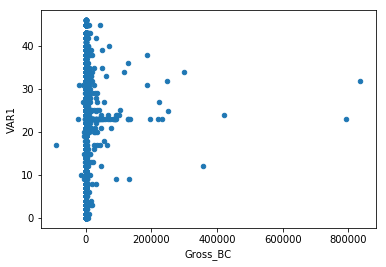

In [20]:
plt = Var_Burn.plot.scatter('Gross_BC','VAR1')

In [21]:
## Calculate how many outliers there are from above scatter where value > 5k and under 0
(Var_Burn.loc[Var_Burn.Gross_BC < 0, 'Gross_BC'].count())+(Var_Burn.loc[Var_Burn.Gross_BC > 5000, 'Gross_BC'].count())

321

In [22]:
Var_Burn_Filt = Var_Burn

In [23]:
# Remove above outliers where sm_burn > 0 and < 5000
Var_Burn_Filt = Var_Burn_Filt[Var_Burn_Filt['Gross_BC'] < 5000]

In [24]:
Var_Burn_Filt = Var_Burn_Filt[Var_Burn_Filt['Gross_BC'] > 0]

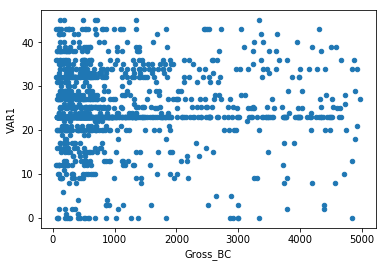

In [25]:
plt = Var_Burn_Filt.plot.scatter('Gross_BC','VAR1')

## Create aggregated table
***

In [26]:
VAR_Burn_ag = Var_Burn_Filt

In [27]:
VAR_summary = VAR_Burn_ag.groupby(['VAR1','VAR2','VEHICLE_AGE','VEHICLE_VALUE','RI_AGE','CREDIT_SCORE'])['Gross_BC'].mean()

In [28]:
VAR_summary = VAR_summary.reset_index()
VAR_summary.columns = ['VAR1','VAR2','VEHICLE_AGE','VEHICLE_VALUE','RI_AGE','CREDIT_SCORE','Avg_Gross_BC']

In [29]:
VAR_summary.head(5)

,VAR1,VAR2,VEHICLE_AGE,VEHICLE_VALUE,RI_AGE,CREDIT_SCORE,Avg_Gross_BC
0,0.0,0.0,0,78000,47,826,1384.673398
1,0.0,0.0,1,58500,38,575,2873.997759
2,0.0,0.0,4,18500,77,762,509.103832
3,0.0,0.0,9,4000,76,853,2996.822359
4,0.0,4.0,1,11000,34,567,276.974297


In [30]:
VAR_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225 entries, 0 to 1224
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   VAR1           1225 non-null   float64
 1   VAR2           1225 non-null   float64
 2   VEHICLE_AGE    1225 non-null   int64  
 3   VEHICLE_VALUE  1225 non-null   int64  
 4   RI_AGE         1225 non-null   int64  
 5   CREDIT_SCORE   1225 non-null   int64  
 6   Avg_Gross_BC   1225 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 67.1 KB


## Test feature/varibale importance using SHAP
***

In [31]:
!pip install shap

In [32]:
# New df for same reasons as above
VAR_MODEL = VAR_summary

In [33]:
# Declare feature vector and target variable
X = VAR_MODEL[['VAR1','VAR2','VEHICLE_AGE','VEHICLE_VALUE','RI_AGE','CREDIT_SCORE']]
y = VAR_MODEL['Avg_Gross_BC']

In [34]:
# Split the data into train and test data:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [35]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, n_estimators=10, random_state=0)

In [36]:
y_pred = model.predict(X_test)

In [37]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)**(0.5)
mse

1238.8394581294629

In [38]:
# import shap library
import shap

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [39]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train)

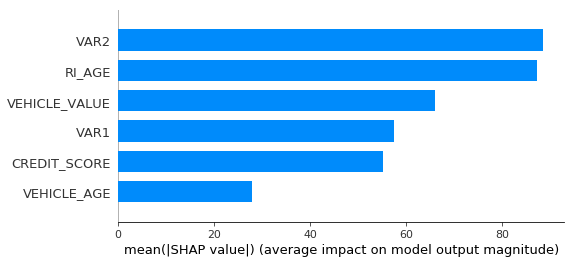

In [40]:
## SHAP feature importance
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

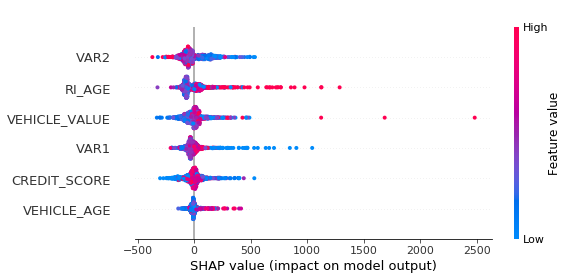

In [41]:
## SHAP Summary Plot
shap.summary_plot(shap_values, X_train)

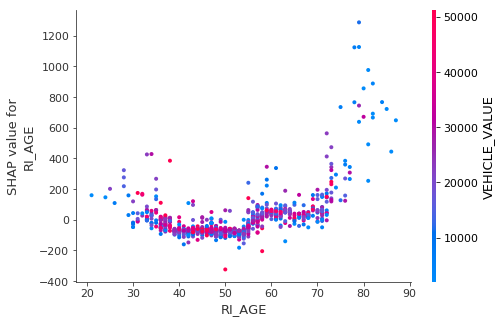

In [42]:
## SHAP Dependence Plot
shap.dependence_plot('RI_AGE', shap_values, X_train)

### Test model once more, without specific variables
***

In [43]:
# New df for same reasons as above
VAR_MODEL2 = VAR_summary

In [44]:
# Declare feature vector and target variable
X = VAR_MODEL2[['VEHICLE_AGE','VEHICLE_VALUE','RI_AGE','CREDIT_SCORE']]
y = VAR_MODEL2['Avg_Gross_BC']

In [45]:
# Split the data into train and test data:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [46]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, n_estimators=10, random_state=0)

In [47]:
y_pred = model.predict(X_test)

In [48]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)**(0.5)
mse

1243.7975606956256

In [49]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

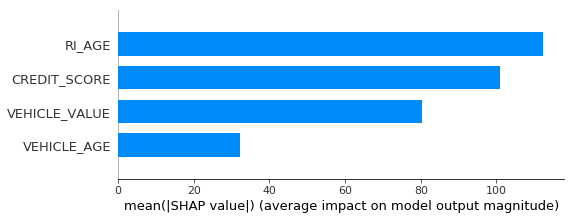

In [50]:
## SHAP feature importance
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")